#cnn

In [ ]:
from google.colab import drive
drive.mount('//content//drive')

Drive already mounted at //content//drive; to attempt to forcibly remount, call drive.mount("//content//drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ML'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/ML/Brain_Tumor_Detection.ipynb
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(16).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(18).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(100).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(10).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(15).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(12).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(19).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(17).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(13).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(14).jpg
/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glio

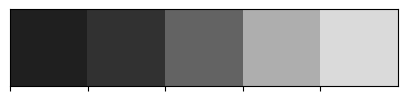

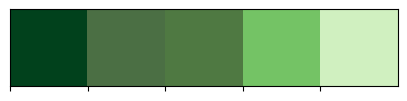

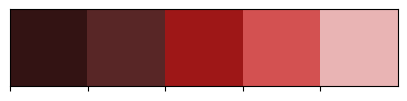

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/ML/Brain Tumor classification','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/ML/Brain Tumor classification','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:30<00:00,  2.39it/s]


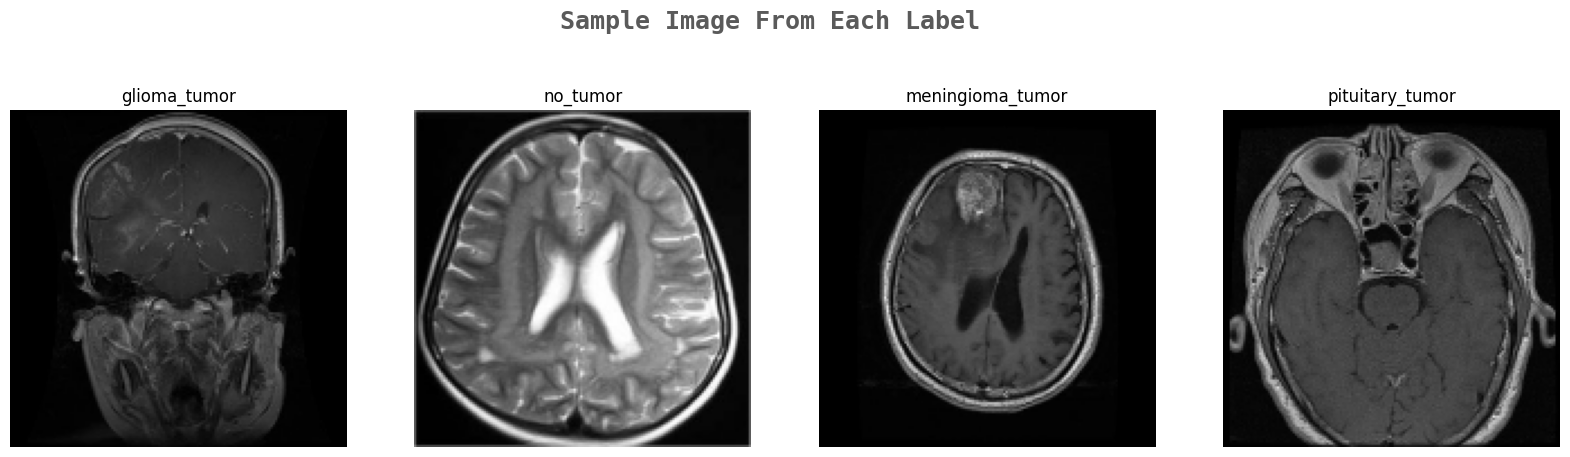

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3729, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)


In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
95/95 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8407
Epoch 1: val_accuracy improved from -inf to 0.88690, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 61s 211ms/step - loss: 0.4104 - accuracy: 0.8407 - val_loss: 0.4108 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 2/12
95/95 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9301
Epoch 2: val_accuracy improved from 0.88690 to 0.91369, saving model to effnet.h5
95/95 [==============================] - 13s 141ms/step - loss: 0.1896 - accuracy: 0.9301 - val_loss: 0.2643 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 3/12
95/95 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9692
Epoch 3: val_accuracy improved from 0.91369 to 0.95833, saving model to effnet.h5
95/95 [==============================] - 15s 154ms/step - loss: 0.1058 - accuracy: 0.9692 - val_loss: 0.1111 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/12
95/95 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9755
Epoch 4: val_accuracy did not improve from 0.95833
95/95 [==============================] - 13s 133ms/step - loss: 0.07

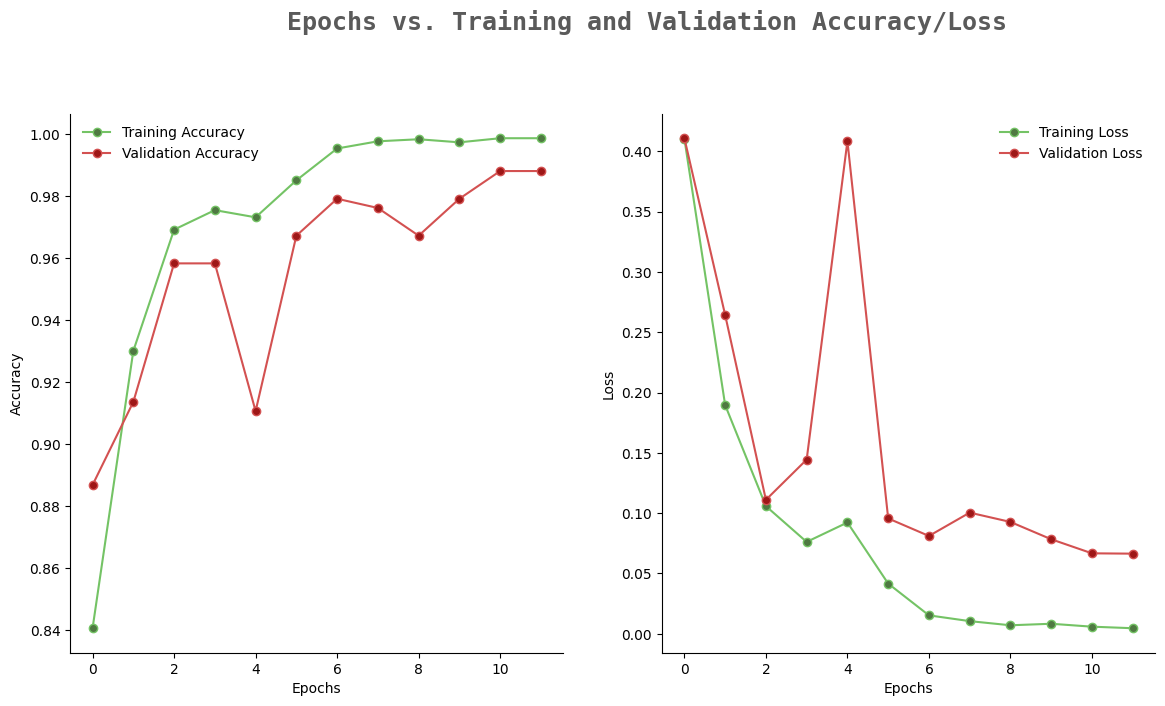

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

12/12 [==============================] - 3s 125ms/step


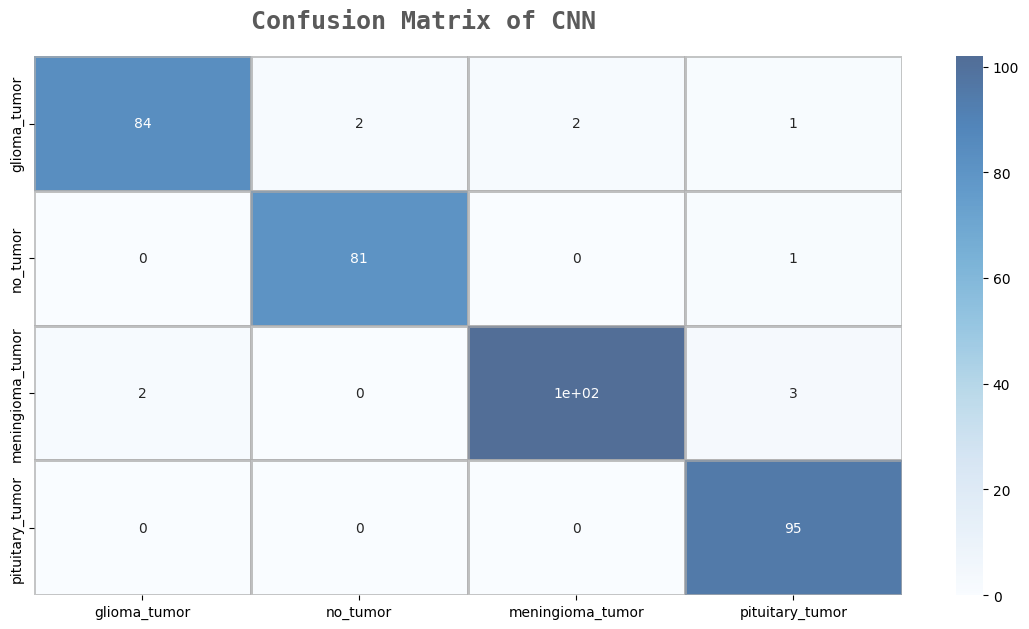

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have y_test_new and pred defined earlier
# y_test_new: true labels, pred: predicted labels

# Create the confusion matrix
cm = confusion_matrix(y_test_new, pred)

# Plot the confusion matrix using seaborn with the "Blues" colormap
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap="Blues", alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Confusion Matrix of CNN', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()


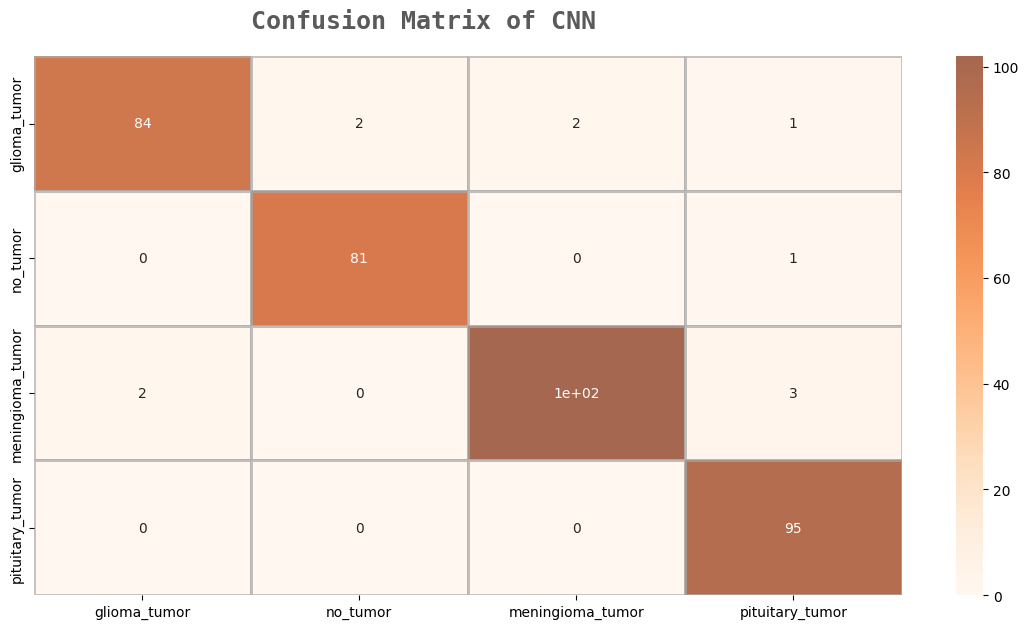

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have y_test_new and pred defined earlier
# y_test_new: true labels, pred: predicted labels

# Create the confusion matrix
cm = confusion_matrix(y_test_new, pred)

# Plot the confusion matrix using seaborn with the "Oranges" colormap
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap="Oranges", alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Confusion Matrix of CNN', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()


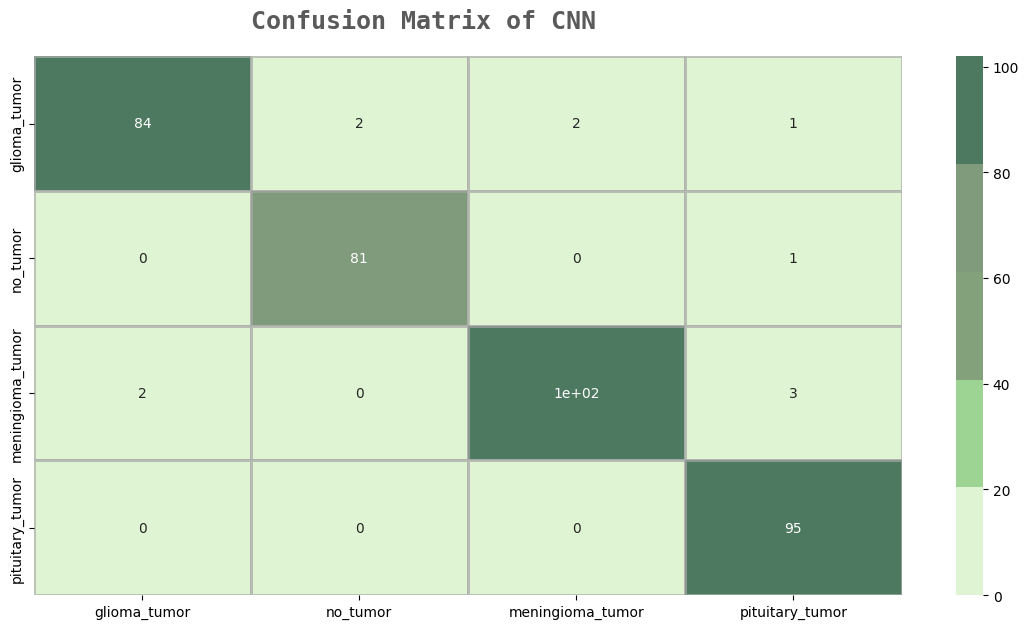

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Confusion Matrix of CNN',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        89
           1       0.98      0.99      0.98        82
           2       0.98      0.95      0.97       107
           3       0.95      1.00      0.97        95

    accuracy                           0.97       373
   macro avg       0.97      0.97      0.97       373
weighted avg       0.97      0.97      0.97       373



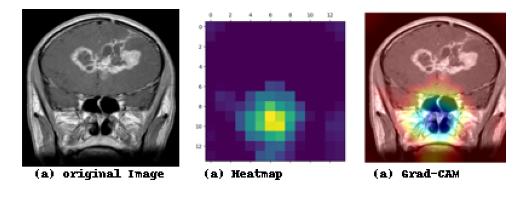

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your image files
img1_path = "image(1).jpg"
img2_path = "giliama1.png"
img3_path = "giliamo1.png"

# Open and resize the images
img1 = Image.open(img1_path).resize((130, 130))
img2 = Image.open(img2_path).resize((130, 130))
img3 = Image.open(img3_path).resize((130, 130))

# Set the size for the combined image with gaps
gap = 10
combined_width = 130 * 3 + 2 * gap
combined_height = 130 + 30  # Added space for captions

# Create a blank image with the desired size
combined_img = Image.new('RGB', (combined_width, combined_height), color='white')

# Paste the images into the blank image with gaps
combined_img.paste(img1, (gap, 0))
combined_img.paste(img2, (130 + gap * 2, 0))
combined_img.paste(img3, (130 * 2 + gap * 3, 0))

# Add captions to each image
draw = ImageDraw.Draw(combined_img)
font = ImageFont.load_default()  # You can also specify a font file or use a different font

# Adjusted coordinates for better placement
draw.text((gap + 10, 130), "(a) original Image", fill='black', font=font)
draw.text((130 + gap * 2 + 10, 130), "(a) Heatmap", fill='black', font=font)
draw.text((130 * 2 + gap * 3 + 10, 130), "(a) Grad-CAM", fill='black', font=font)

# Display the combined image
plt.imshow(combined_img)
plt.axis('off')  # Turn off axis labels
plt.show()


#xai glioma_tumor

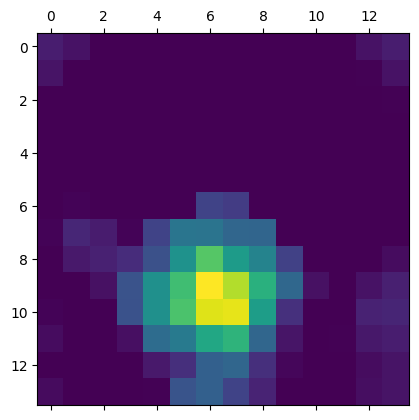

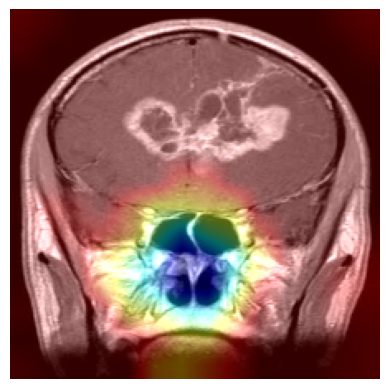

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
#xai glioma_tumor
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(1).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


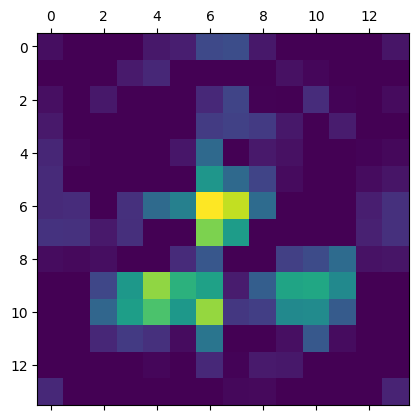

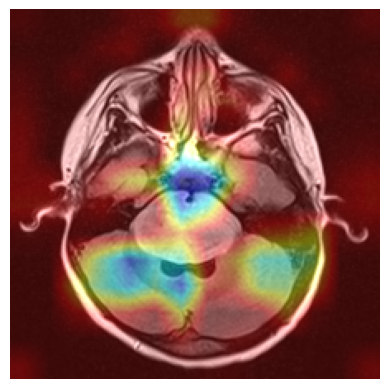

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(2).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


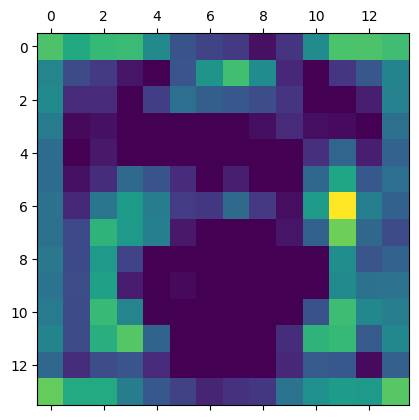

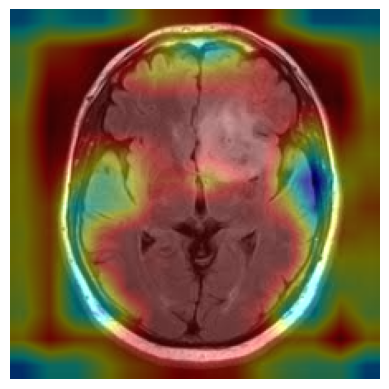

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/glioma_tumor/image(3).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


#xai meningioma_tumor

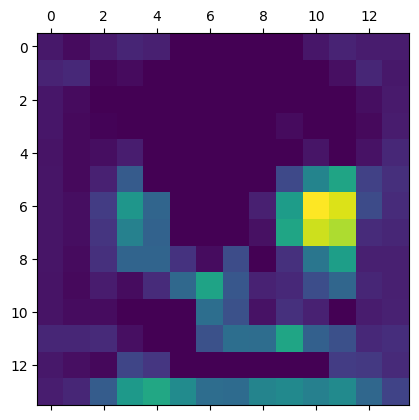

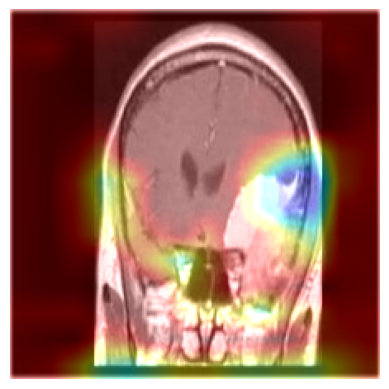

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/meningioma_tumor/image(1).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


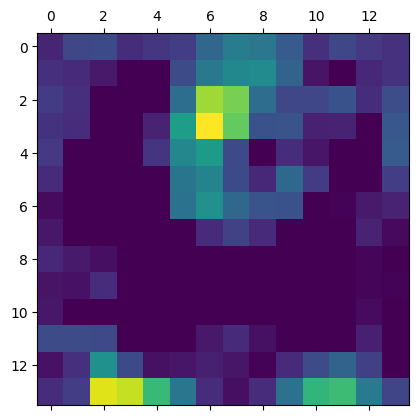

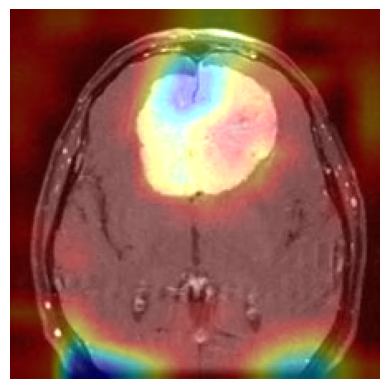

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/meningioma_tumor/image(2).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


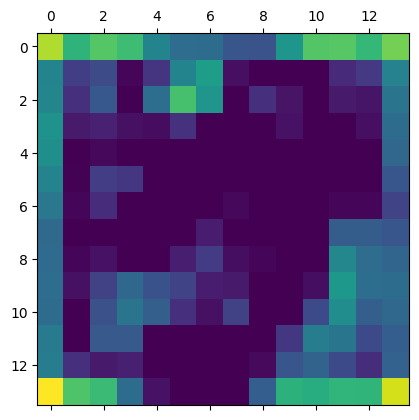

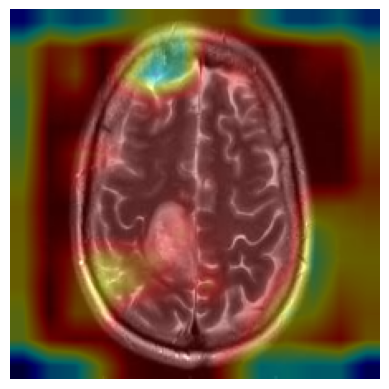

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/meningioma_tumor/image(3).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


#XAI no_tumor

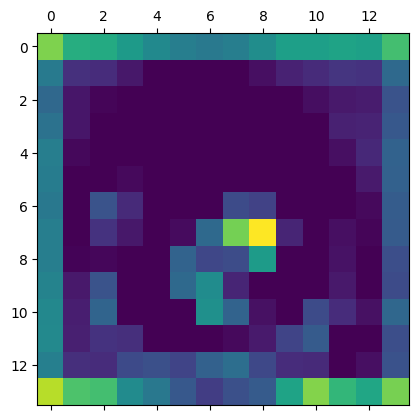

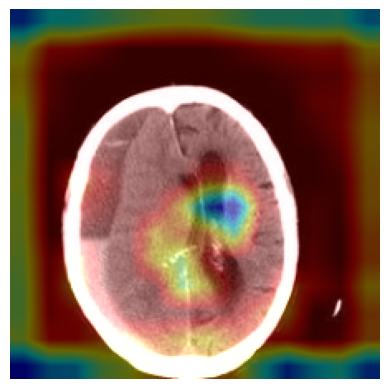

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/no_tumor/image(1).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


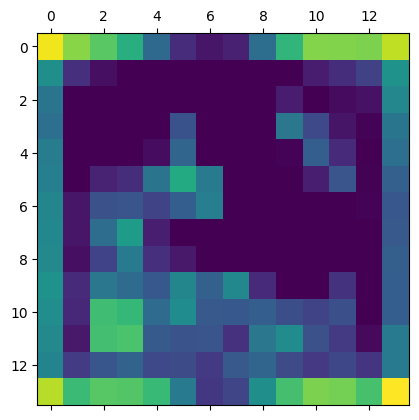

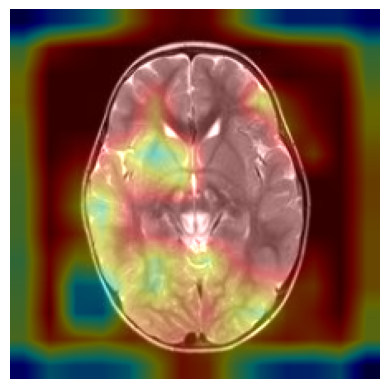

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/no_tumor/image(2).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


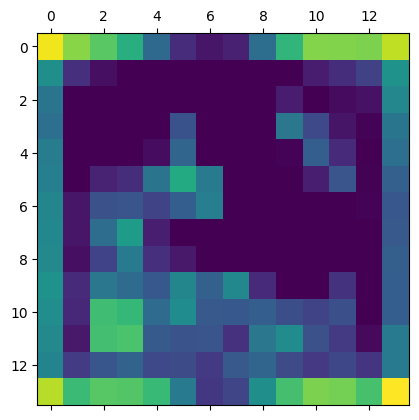

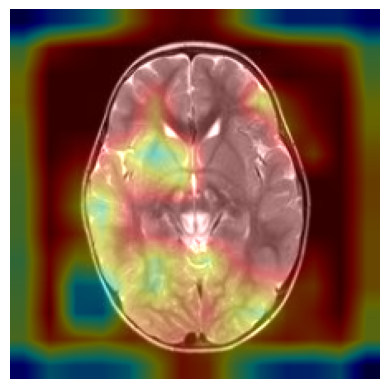

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/no_tumor/image(2).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


#XAI pituitary_tumor

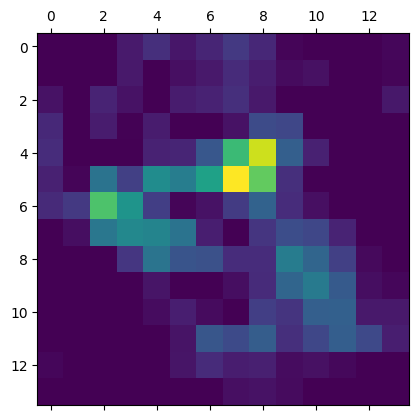

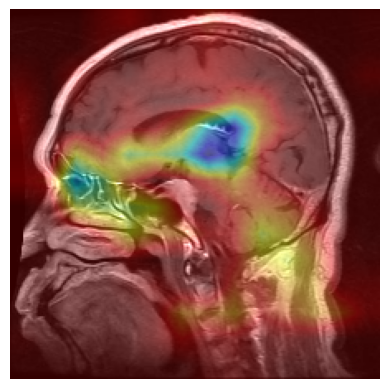

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/pituitary_tumor/image(1).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


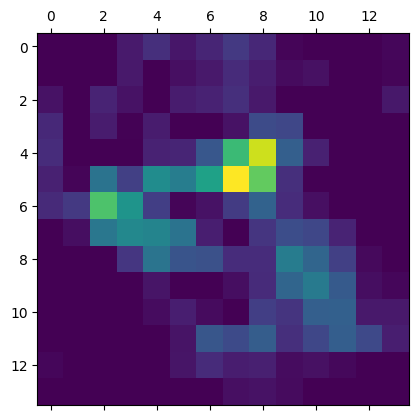

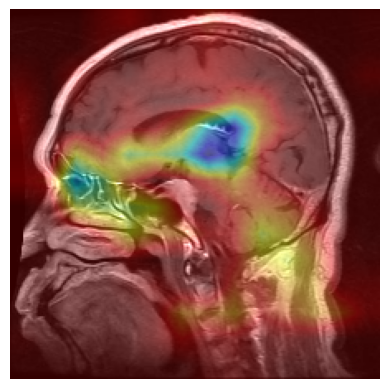

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/pituitary_tumor/image(2).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


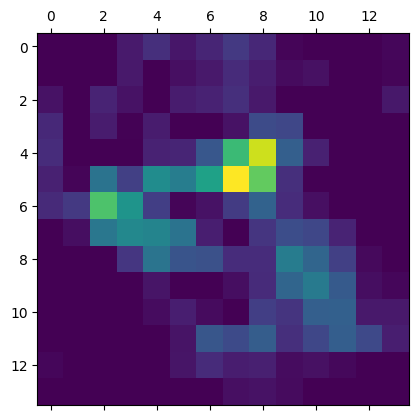

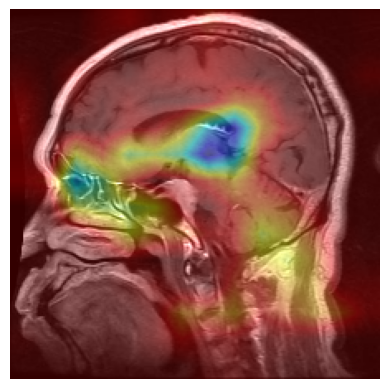

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    # Ensure the result is still an image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load the model and the image
model = VGG16(weights='imagenet')
img_path = '/content/drive/MyDrive/ML/Brain Tumor classification/Testing/pituitary_tumor/image(3).jpg'
img_array = load_image(img_path)

# Generate class activation heatmap
last_conv_layer_name = "block5_conv3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose the heatmap on original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = overlay_gradcam(img, heatmap)

# Display Grad-CAM
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


glioma_tumor : 856 0.26
meningioma_tumor : 826 0.25
no_tumor : 826 0.25
pituitary_tumor : 827 0.25


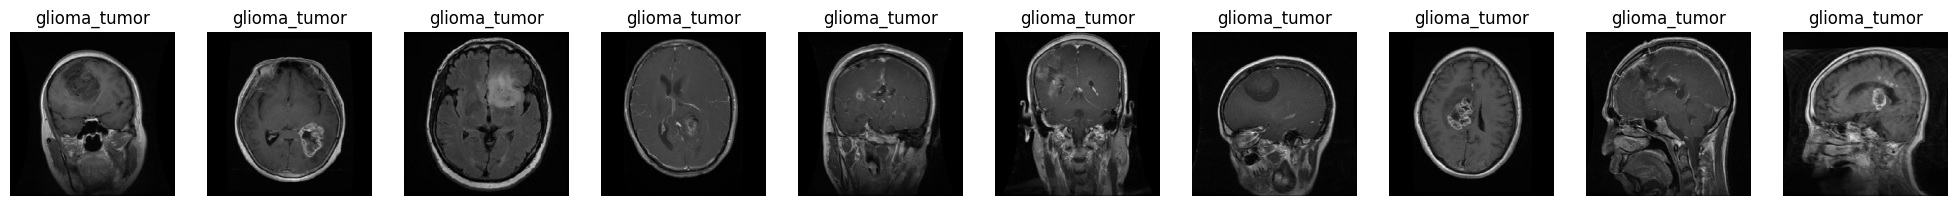

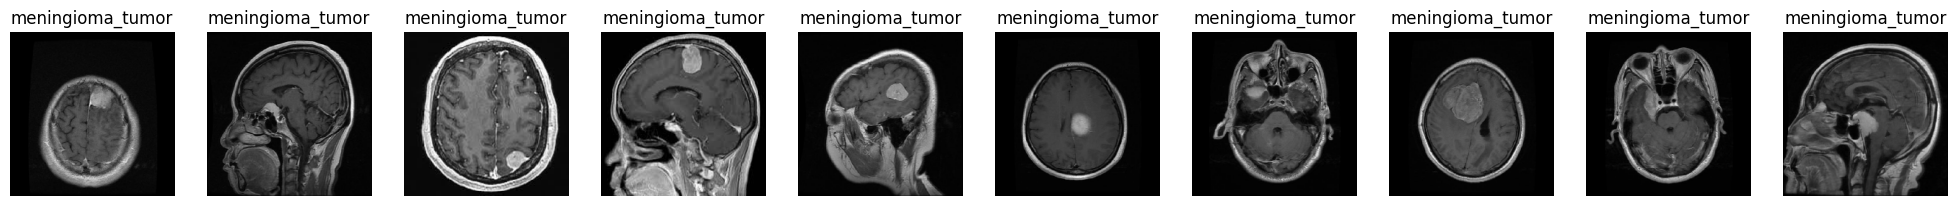

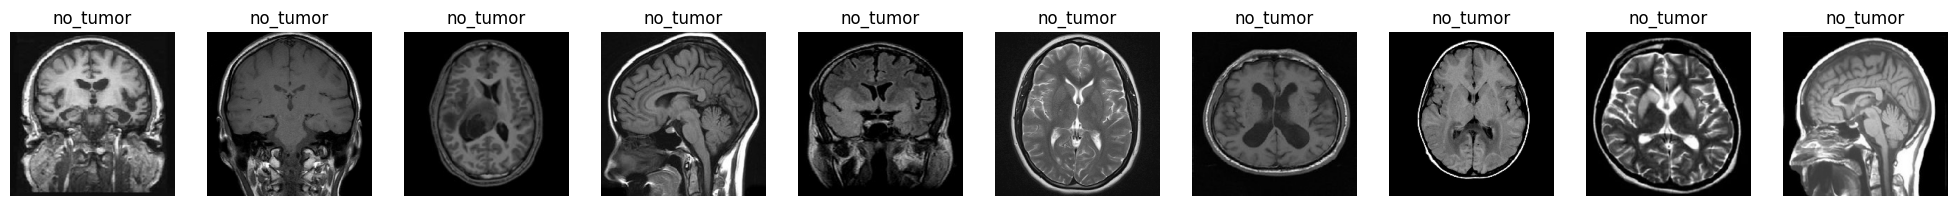

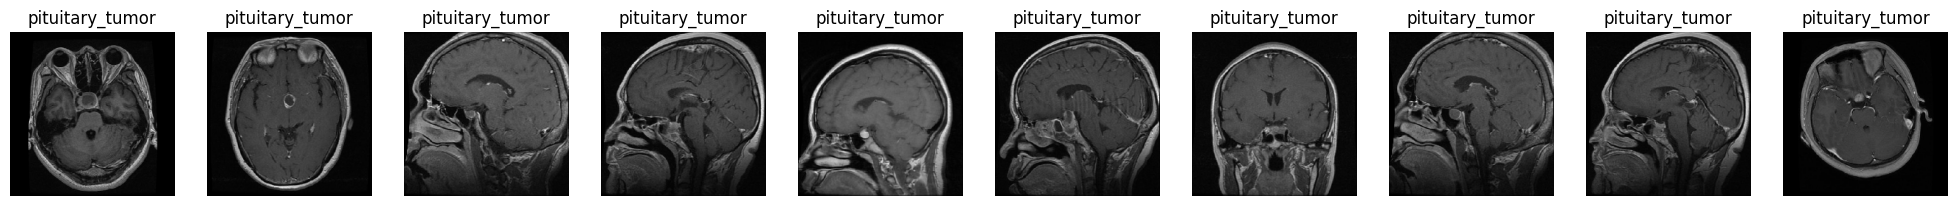

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

<ipython-input-32-b1ccb7e3e769>:97: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
84/84 [==============================] - 90s 690ms/step - loss: 0.5738 - accuracy: 0.7995 - val_loss: 1.9450 - val_accuracy: 0.5457
Epoch 2/10
84/84 [==============================] - 47s 559ms/step - loss: 0.2882 - accuracy: 0.8947 - val_loss: 0.4147 - val_accuracy: 0.8456
Epoch 3/10
84/84 [==============================] - 46s 543ms/step - loss: 0.2456 - accuracy: 0.9055 - val_loss: 1.0230 - val_accuracy: 0.6972
Epoch 4/10
84/84 [==============================] - 45s 530ms/step - loss: 0.1892 - accuracy: 0.9333 - val_loss: 0.6343 - val_accuracy: 0.8081
Epoch 5/10
84/84 [==============================] - 44s 516ms/step - loss: 0.1615 - accuracy: 0.9445 - val_loss: 0.5823 - val_accuracy: 0.8096
Epoch 6/10
84/84 [==============================] - 44s 522ms/step - loss: 0.1332 - accuracy: 0.9464 - val_loss: 0.4036 - val_accuracy: 0.8621
Epoch 7/10
84/84 [==============================] - 44s 528ms/step - loss: 0.1215 - accuracy: 0.9595 - val_loss: 0.3115 - val_accuracy: 0.8936

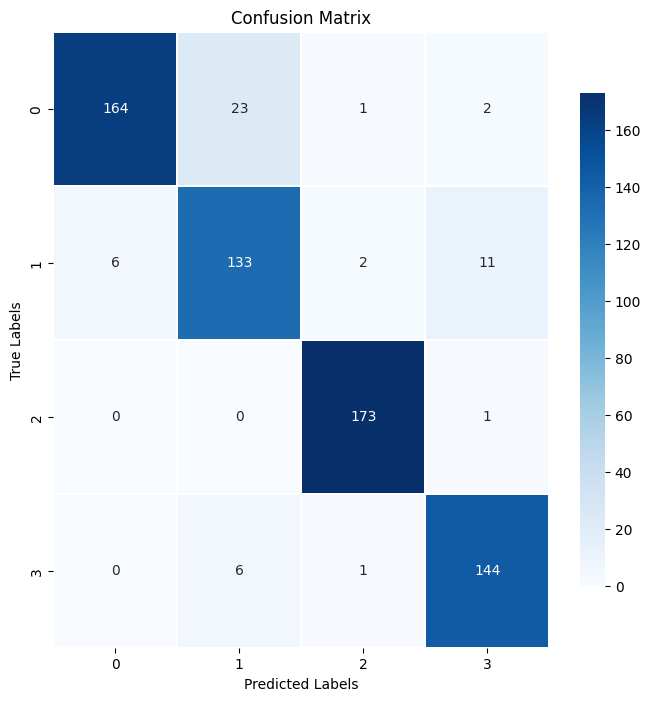

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import copy
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, ResNet50
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Replace these placeholders with your actual data
DIR_PATH = "/content/drive/MyDrive/ML/Brain Tumor classification/Training"
LABEL_TO_CLASS = {"glioma_tumor": 0,
    "meningioma_tumor":    1,
    "no_tumor":   2,
    "pituitary_tumor":       3}  # Example mapping
W, H = 224, 224
SEED = 42
N_CLASSES = len(LABEL_TO_CLASS)
BATCH_SIZE = 32
N_EPOCHS = 10

# Assume CLASS_TO_LABEL is defined somewhere
CLASS_TO_LABEL = {0:"glioma_tumor",
    1:"meningioma_tumor",
    2:"no_tumor",
    3:"pituitary_tumor"}

# Function definitions (use the provided functions)

# Get images and classes
images, classes = get_images(
    dir_path=DIR_PATH,
    label_to_class=LABEL_TO_CLASS,
    w=W,
    h=H,
    seed=SEED,
)

# Check the number of images for each label
n_total_images = images.shape[0]
for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0]
    n_target_cls = indices.shape[0]
    label = CLASS_TO_LABEL[target_cls]
    print(label, ":", n_target_cls, round(n_target_cls / n_total_images, 2))

# Visualize some images / labels
for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0]
    label = CLASS_TO_LABEL[target_cls]

    n_cols = 10  # The number of sample plots
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):
        axs[i].imshow(np.uint8(images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

# Split dataset to train and test
x_train, y_train, x_test, y_test = split_dataset(images, classes)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, N_CLASSES)
y_test = keras.utils.to_categorical(y_test, N_CLASSES)

# Create image data generators
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# Build the model
model = build_model(w=W, h=H, n_classes=N_CLASSES)
model.summary()

# Fit the model
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

# Plot the confusion matrix
plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

In [ ]:
# Example usage for Grad-CAM
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=grad_cam,
    superimpose=superimpose,
    img=images[0],
    cls_true=classes[0],
    class_to_label=CLASS_TO_LABEL,
    cam_name="Grad-CAM",
)

1/1 [==============================] - 0s 24ms/step


RuntimeError: ignored

In [ ]:
# Example usage for Grad-CAM++
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=grad_cam_plus_plus,
    superimpose=superimpose,
    img=images[0],
    cls_true=classes[0],
    class_to_label=CLASS_TO_LABEL,
    cam_name="Grad-CAM++",
)

In [ ]:
# Example usage for Score-CAM
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=score_cam,
    superimpose=superimpose,
    img=images[0],
    cls_true=classes[0],
    class_to_label=CLASS_TO_LABEL,
    cam_name="Score-CAM",
)

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Example usage for Grad-CAM
@tf.function
def predict_with_model(model, x):
    return model.predict(x)

# Call the predict function in graph mode
predictions = predict_with_model(model, x)

# Enable eager execution again if needed
tf.compat.v1.enable_eager_execution()


NameError: ignored

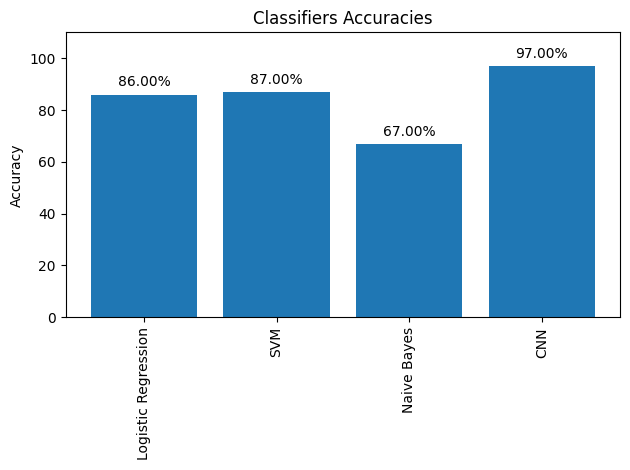

In [ ]:
import matplotlib.pyplot as plt


models = ['Logistic Regression','SVM', 'Naive Bayes','CNN']
accuracies =  [86, 87, 67, 97]


plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Classifiers Accuracies')
plt.xticks(rotation='vertical')

# Display the accuracies at the top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

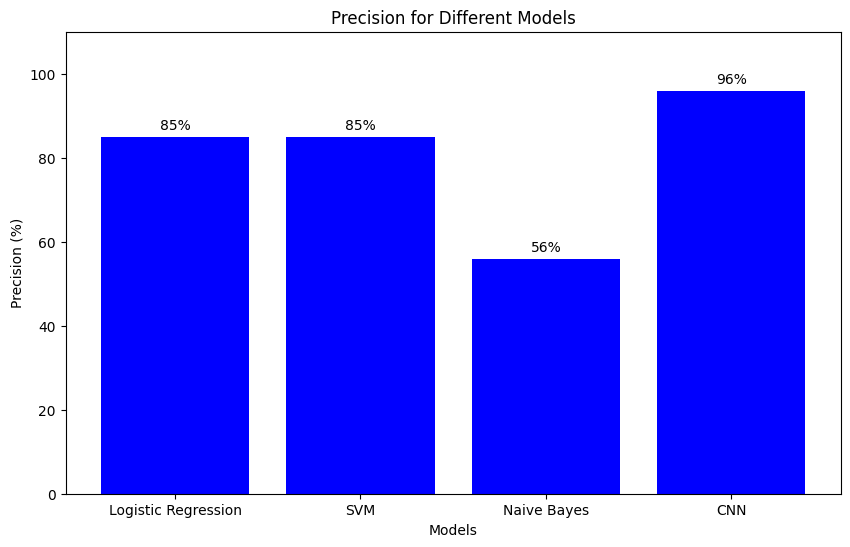

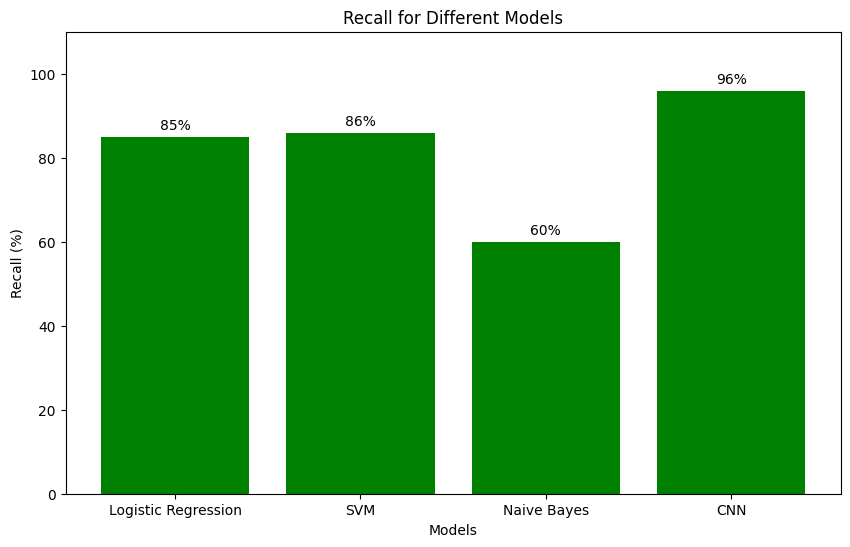

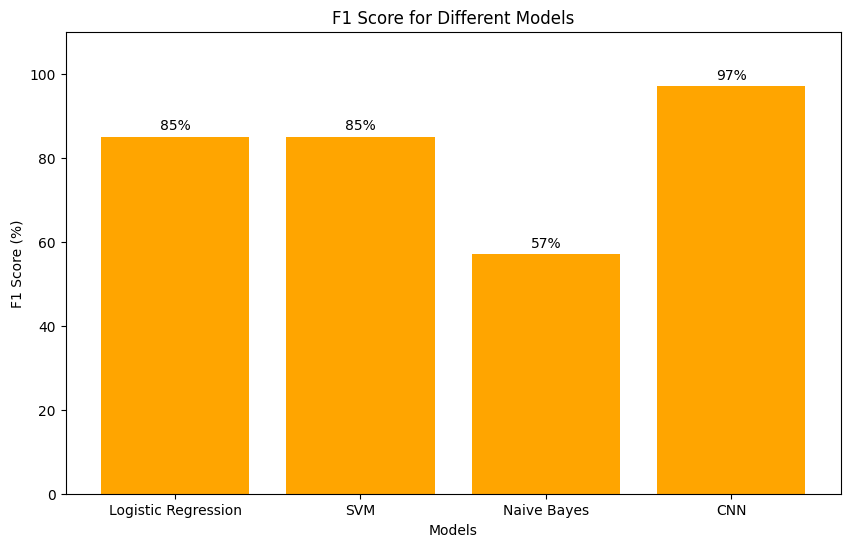

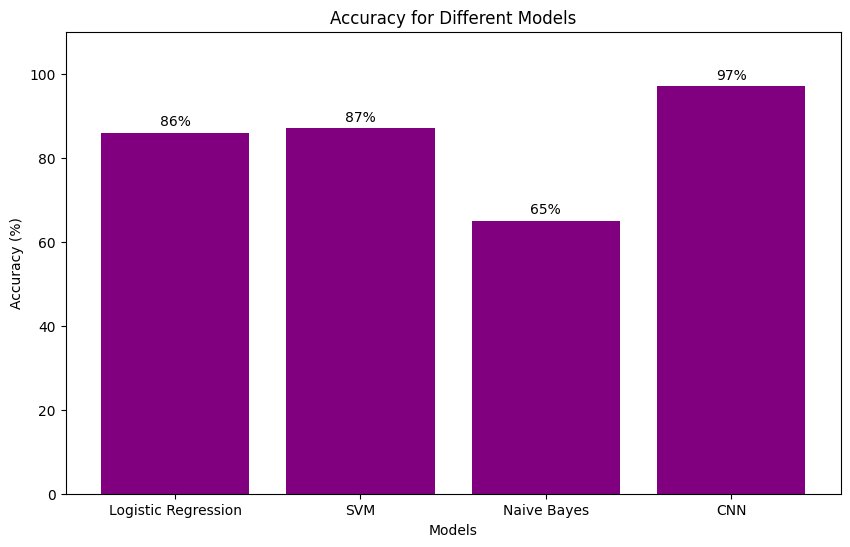

In [ ]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'SVM', 'Naive Bayes', 'CNN']
precision = [85, 85, 56, 96]
recall = [85, 86, 60, 96]
f1_score = [85, 85, 57, 97]
accuracy = [86, 87, 65, 97]

def plot_with_percentage_values(metric, metric_name, color):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, metric, color=color)
    plt.title(f'{metric_name} for Different Models')
    plt.xlabel('Models')
    plt.ylabel(f'{metric_name} (%)')
    plt.ylim(0, 110)

    for bar, value in zip(bars, metric):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                 f'{value}%', ha='center', va='bottom', color='black')

    plt.show()

# Plot Precision
plot_with_percentage_values(precision, 'Precision', 'blue')

# Plot Recall
plot_with_percentage_values(recall, 'Recall', 'green')

# Plot F1 Score
plot_with_percentage_values(f1_score, 'F1 Score', 'orange')

# Plot Accuracy
plot_with_percentage_values(accuracy, 'Accuracy', 'purple')
